In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram
import sounddevice as sd
from IPython.display import Audio, display
from scipy.signal import get_window


In [504]:
# === LOAD AUDIO ===
file_path = 'Sound/avicii-style-guitar-loop-301393.wav'

sr, audio = wavfile.read(file_path) # load the audio and get sr and data
print(sr)
if audio.ndim == 2: audio_data = audio.mean(axis=1) # convert stereo into mono
audio = audio / np.max(np.abs(audio)) # normalize the audio to [-1 to 1]

44100


In [505]:
# === Change parameters ===

# === Set Analysis Parameters ===
fft_size = 25600       # Number of points in FFT
w_len = 3200           # Window length for analysis (in samples) - samples pr segment for spectogram
ovlps = w_len // 2     # Overlap between windows (50%)
db_scale = False       # Set True to display magnitudes in dB, if not used it is linear.
w_type = 'hann'        # Type of window function  - others can be used


# Print parameter info
print("sample rate:", sr)
print("fft size:", fft_size)
print("window length:", w_len)
print("overlap size:", ovlps)

sampling rate:  44100
fft size:  25600
window length:  3200
overlap size:  1600


In [506]:
# Display audio player
display(Audio(data=audio, rate=sr))

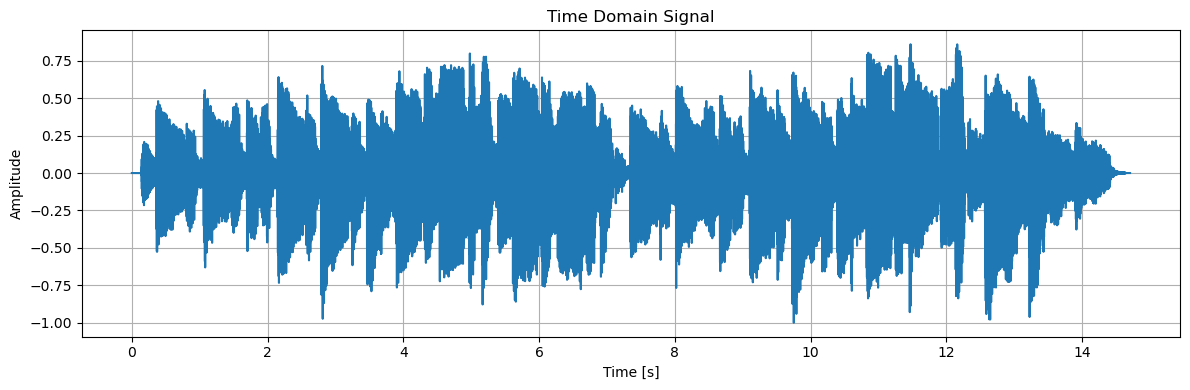

In [507]:
# === TIME DOMAIN PLOT ===
# === Plot Time Domain Signal ===
duration = len(audio) / sr                         # Duration in seconds
time_axis = np.linspace(0, duration, len(audio))  # Time axis for plotting

plt.figure(figsize=(12, 4))
plt.plot(time_axis, audio)
plt.title("Time Domain Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

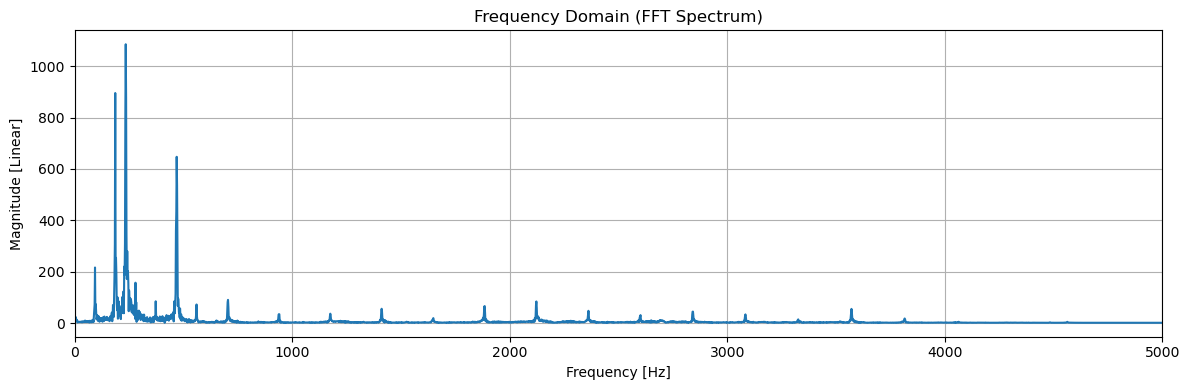

In [508]:
# FFT
fft_result = np.fft.fft(audio, n=fft_size)  # Perform FFT
mag_spec = np.abs(fft_result)[:fft_size // 2] + 1  # Magnitude spectrum

# Convert to dB if enabled
if db_scale:
    mag_spec = 20 * np.log10(mag_spec)

# Frequency axis
freq_axis = np.fft.fftfreq(fft_size, d=1 / sr)[:fft_size // 2]

plt.figure(figsize=(12, 4))
plt.plot(freq_axis, mag_spec)
plt.xlim(0, 5000)
plt.title("Frequency Domain (FFT Spectrum)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [{}]".format("dB" if db_scale else "Linear"))
plt.grid(True)
plt.tight_layout()
plt.show()

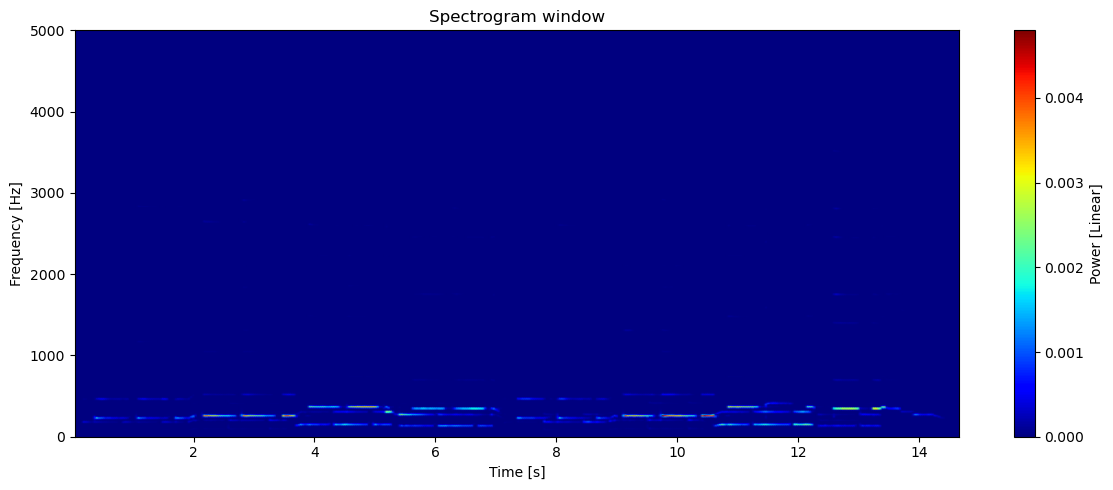

In [510]:
# SPECTROGRAM
frequencies, times, spec = spectrogram(
    audio,
    fs=sr,
    window=w_type,
    nperseg=w_len,
    noverlap=ovlps
)

# Apply dB scaling if enabled
if db_scale:
    spec = 10 * np.log10(spec + 1e-10) + 100

plt.figure(figsize=(12, 5))
plt.ylim(0, 5000)
plt.pcolormesh(times, frequencies, spec, shading='gouraud', cmap='jet')
plt.title("Spectrogram")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.colorbar(label='Power [{}]'.format("dB" if db_scale else "Linear"))
plt.tight_layout()
plt.show()

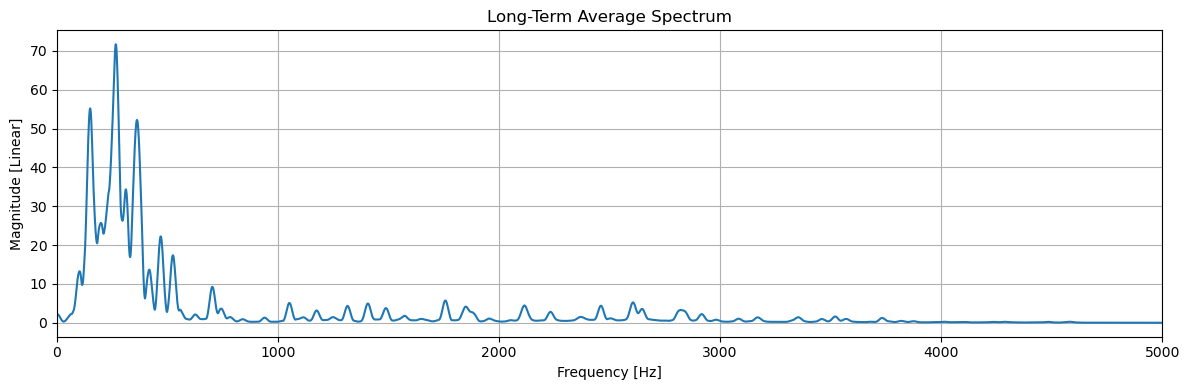

In [511]:
# Break audio into overlapping segments
step = w_len - ovlps                                # Step size for segments
num_segments = (len(audio) - w_len) // step + 1     # Number of segments
window = get_window(w_type, w_len)                  # Analysis window
spec_acc = np.zeros(fft_size // 2)                  # Accumulator for magnitude spectrum

# Loop over segments and accumulate spectra
for i in range(num_segments):
    start = i * step
    segment = audio[start:start + w_len] * window
    seg_fft = np.fft.fft(segment, n=fft_size)
    mag = np.abs(seg_fft[:fft_size // 2])
    spec_acc += mag

# Average and optionally convert to dB
avg_spec = spec_acc / num_segments
if db_scale:
    avg_spec = 20 * np.log10(avg_spec + 1e-10)

# Plot long-term average spectrum
plt.figure(figsize=(12, 4))
plt.plot(freq_axis, avg_spec)
plt.xlim(0, 5000)
plt.title("Long-Term Average Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [{}]".format("dB" if db_scale else "Linear"))
plt.grid(True)
plt.tight_layout()
plt.show()